# Test for inversecovariance benchmarking against CorrCal-C implimentation

In [1]:
import sys
from pathlib import Path
parent_dir = Path.cwd().parent
sys.path.insert(0, str(parent_dir))

In [2]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from corrcal import sparse
from zp_puregpu_funcs_py import *
from invcov import *

hera_cal is not installed. Some gridding features unavailable.
pyfof is not installed. Some gridding features unavailable.


In [7]:
#let's benchmark the zeropad functions

#the main parametes describing our problem.
n_bl = 120000
n_eig = 3
n_src = 5
xp = np  #run things on the gpu using cupy

#random array of edges for the diffuse matrix
edges = xp.unique(xp.random.randint(1, n_bl-1, size = 500))
edges = xp.concatenate((xp.array([0]), edges, xp.array([n_bl])))
# print(f"The edges of the redundant blocks have indices{edges}")

#some random noise, diffuse, and source covariance matrices
sim_noise_mat = xp.random.rand(n_bl)**2   #in principle this is squared since is a variance
sim_diff_mat = xp.random.rand(n_bl, n_eig)
sim_src_mat = xp.random.rand(n_bl, n_src)


result = str(benchmark(zeropad, (sim_diff_mat, edges, xp), n_repeat=1000))
result = result.split()
cpu_t = float(result[3]) / 1e6
gpu_t = float(result[14]) / 1e6
print(f"Time on CPU: {cpu_t:.6f}s")
print(f"Time on GPU: {gpu_t:.6f}s")

Time on CPU: 0.001402s
Time on GPU: 0.001589s


In [3]:
#the main parametes describing our problem.
n_bl = 120000
n_eig = 3
n_src = 5
xp = np  #run things on the gpu using cupy

#random array of edges for the diffuse matrix
edges = xp.unique(xp.random.randint(1, n_bl-1, size = 500))
edges = xp.concatenate((xp.array([0]), edges, xp.array([n_bl])))
# print(f"The edges of the redundant blocks have indices{edges}")

#some random noise, diffuse, and source covariance matrices
sim_noise_mat = xp.random.rand(n_bl) + 0.1   #in principle this is squared since is a variance
sim_diff_mat = xp.random.rand(n_bl, n_eig)
sim_src_mat = xp.random.rand(n_bl, n_src)

In [4]:
print(sim_diff_mat.dtype)
print(type(sim_diff_mat))  #make sure this is actually on the cpu

float64
<class 'numpy.ndarray'>


In [5]:
cov_instance = sparse.SparseCov(sim_noise_mat, sim_src_mat, sim_diff_mat, edges=edges, n_eig=n_eig)

In [6]:
cov_inv, log_det = cov_instance.inv(return_det=True)

In [7]:
print(log_det)

3120.14186231194


In [8]:
test_results = str(benchmark(cov_instance.inv, (True,), n_repeat=100))
test_results = test_results.split()
cpu_t = float(test_results[3])/1e6
gpu_t = float(test_results[14])/1e6
print(f"Time on cpu: {cpu_t:.6f}s")
print(f"Time on gpu: {gpu_t:.6f}s")

Time on cpu: 0.106751s
Time on gpu: 0.107455s


In [26]:
#the main parametes describing our problem.
n_bl = 120000
n_eig = 3
n_src = 5
xp = cp  #run things on the gpu using cupy

#random array of edges for the diffuse matrix
edges = xp.unique(xp.random.randint(1, n_bl-1, size = 500))
edges = xp.concatenate((xp.array([0]), edges, xp.array([n_bl])))
# print(f"The edges of the redundant blocks have indices{edges}")

#some random noise, diffuse, and source covariance matrices
sim_noise_mat = xp.random.rand(n_bl, dtype = 'float64') + 0.1   #in principle this is squared since is a variance
sim_diff_mat = xp.random.rand(n_bl, n_eig, dtype = 'float64')
sim_src_mat = xp.random.rand(n_bl, n_src, dtype = 'float64')

In [27]:
print(sim_diff_mat.dtype)
print(type(sim_diff_mat))

float64
<class 'cupy.ndarray'>


In [28]:
#zeropad the noise, diff, source mats
zp_sim_noise_mat_inv, largest_block, n_blocks = zeroPad(sim_noise_mat, edges, return_inv=True)  #return inverse set to True to get around div by 0 issue
zp_sim_noise_mat, largest_block, n_blocks = zeroPad(sim_noise_mat, edges, return_inv=False)  #return inverse set to False for sims later on
zp_sim_diff_mat, largest_block, n_blocks = zeroPad(sim_diff_mat, edges, return_inv=False)
zp_sim_src_mat, largest_block, n_blocks = zeroPad(sim_src_mat, edges, return_inv=False)

#Need to reshape to give an extra dimension of n_blocks to be compatible with inv cov routine
sim_noise_mat_2d = zp_sim_noise_mat_inv.reshape(n_blocks, largest_block)   #Again, its worth noting the values of the noise mat are really 1/noise_vals here
sim_diff_mat_3d = zp_sim_diff_mat.reshape(n_blocks, largest_block, n_eig)
sim_src_mat_3d = zp_sim_src_mat.reshape(n_blocks, largest_block, n_src)

In [33]:
test_results = str(benchmark(inverse_covariance, (sim_noise_mat_2d, sim_diff_mat_3d, sim_src_mat_3d, edges, xp, True, True), n_repeat=100))
test_results = test_results.split()
cpu_t = float(test_results[3])/1e6
gpu_t = float(test_results[14])/1e6
print(f"Time on cpu: {cpu_t:.6f}s")
print(f"Time on gpu: {gpu_t:.6f}s")

Time on cpu: 0.002354s
Time on gpu: 0.032401s


In [13]:
logdet, N_inv, Del_p, Sig_p = inverse_covariance(sim_noise_mat_2d, sim_diff_mat_3d, sim_src_mat_3d, edges=edges, xp = xp , ret_det = True, N_is_inv=True)

In [14]:
print(logdet)

3112.854296500289


### Comparing accuracy of gpu-inverse cov agaisnt cpu-corrcal

In [41]:
#the main parametes describing our problem.
n_bl = 120000
n_eig = 3
n_src = 5
xp = np  #run things on the gpu using cupy

#random array of edges for the diffuse matrix
edges = xp.unique(xp.random.randint(1, n_bl-1, size = 500))
edges = xp.concatenate((xp.array([0]), edges, xp.array([n_bl])))
# print(f"The edges of the redundant blocks have indices{edges}")

#some random noise, diffuse, and source covariance matrices
sim_noise_mat = xp.random.rand(n_bl) + 0.1   #in principle this is squared since is a variance
sim_diff_mat = xp.random.rand(n_bl, n_eig)
sim_src_mat = xp.random.rand(n_bl, n_src)

# print(sim_diff_mat.dtype)
# print(type(sim_diff_mat))  #print out which chip is running on

#zeropad the noise, diff, source mats if things are running on the gpu
zp_sim_noise_mat_inv, largest_block, n_blocks = zeroPad(sim_noise_mat, edges, return_inv=True)  #return inverse set to True to get around div by 0 issue
zp_sim_noise_mat, largest_block, n_blocks = zeroPad(sim_noise_mat, edges, return_inv=False)  #return inverse set to False for sims later on
zp_sim_diff_mat, largest_block, n_blocks = zeroPad(sim_diff_mat, edges, return_inv=False)
zp_sim_src_mat, largest_block, n_blocks = zeroPad(sim_src_mat, edges, return_inv=False)

#Need to reshape to give an extra dimension of n_blocks to be compatible with inv cov routine
sim_noise_mat_2d = zp_sim_noise_mat_inv.reshape(n_blocks, largest_block)   #Again, its worth noting the values of the noise mat are really 1/noise_vals here
sim_diff_mat_3d = zp_sim_diff_mat.reshape(n_blocks, largest_block, n_eig)
sim_src_mat_3d = zp_sim_src_mat.reshape(n_blocks, largest_block, n_src)

#when running on the cpu, need to create an instance of the sparse cov class
cov_instance = sparse.SparseCov(sim_noise_mat, sim_src_mat, sim_diff_mat, edges=edges, n_eig=n_eig)

#return then inverse covariance and log(det), then print out the log det
cov_inv, log_det = cov_instance.inv(return_det=True)
print(f"The log(det) after running cpu-corrcal is: {log_det}")

#Now return the log_det, and all inverse matrices via the gpu covariance inverse routine, and print out the log(det)
sim_noise_mat_2d = cp.array(sim_noise_mat_2d)
sim_diff_mat_3d = cp.array(sim_diff_mat_3d)
sim_src_mat_3d = cp.array(sim_src_mat_3d)
edges = cp.array(edges)
xp = cp
logdet, N_inv, Del_p, Sig_p = inverse_covariance(sim_noise_mat_2d, sim_diff_mat_3d, sim_src_mat_3d, edges=edges, xp = xp , ret_det = True, N_is_inv=True)
print()
print(f"log(det) when running with gpu routine is: {logdet}")

The log(det) after running cpu-corrcal is: 3067.868012022119

log(det) when running with gpu routine is: 3067.5422371098184


### Comparing speed of cpu vs gpu covariance inverse

In [18]:
#simulation params
n_bl = 200000
n_eig = 5
n_src = 10
xp = np  #run things on the gpu using cupy

#random array of edges for the diffuse matrix
edges = xp.unique(xp.random.randint(1, n_bl-1, size = 500))
edges = xp.concatenate((xp.array([0]), edges, xp.array([n_bl])))
# print(f"The edges of the redundant blocks have indices{edges}")

#some random noise, diffuse, and source covariance matrices
sim_noise_mat = xp.random.rand(n_bl) + 0.1   #in principle this is squared since is a variance
sim_diff_mat = xp.random.rand(n_bl, n_eig)
sim_src_mat = xp.random.rand(n_bl, n_src)

cov_instance = sparse.SparseCov(sim_noise_mat, sim_src_mat, sim_diff_mat, edges=edges, n_eig=n_eig)

In [19]:
test_results = str(benchmark(cov_instance.inv, (True,), n_repeat=100))
test_results = test_results.split()
cpu_t = float(test_results[3])/1e6
gpu_t = float(test_results[14])/1e6
print(f"Time on cpu: {cpu_t:.6f}s")
print(f"Time on gpu: {gpu_t:.6f}s")

Time on cpu: 0.137878s
Time on gpu: 0.139047s


In [11]:
# bl_array = np.array([1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6])
# bl_array = np.array([1, 2, 3, 4, 5, 6])
# bl_array = np.random.randint(1, 120000, size = 300)
bl_array = (np.logspace(1, 5.5, 65, base=10)).astype(int)

n_eig = 3
n_src = 5
xp = np  #run things on the gpu using cupy

# bl_array = np.array([100, 500, 1000, 5000, 10000, 13000, 15000, 50000, 80000, 100000, 110000, 120000])
# bl_array = (10**bl_array)
# print(bl_array)
cov_instance = []
for bl in bl_array:
    edges = xp.unique(xp.random.randint(1, bl-1, size = max(int(np.sqrt(bl)), 1)))
    edges = xp.concatenate((xp.array([0]), edges, xp.array([bl])))
    # print(f"The edges of the redundant blocks have indices{edges}")

    #some random noise, diffuse, and source covariance matrices
    sim_noise_mat = xp.random.rand(bl) + 0.1   #in principle this is squared since is a variance
    sim_diff_mat = xp.random.rand(bl, n_eig)
    sim_src_mat = xp.random.rand(bl, n_src)

    cov_instance_trial = sparse.SparseCov(sim_noise_mat, sim_src_mat, sim_diff_mat, edges=edges, n_eig=n_eig)
    cov_instance.append(cov_instance_trial)

In [12]:
# print(cov_instance)

In [13]:
cpu_times = np.array([])
for i, inst in enumerate(cov_instance):
    print(f"Outputting inst {i}")
    test_results = str(benchmark(inst.inv, (True,), n_repeat=10))
    test_results = test_results.split()
    cpu_t = float(test_results[3])/1e6
    gpu_t = float(test_results[14])/1e6
    print(f"Time on cpu: {cpu_t:.6f}s")
    # print(f"Time on gpu: {gpu_t:.6f}s")
    cpu_times = np.append(cpu_times, cpu_t)

Outputting inst 0
Time on cpu: 0.017161s
Outputting inst 1
Time on cpu: 0.016834s
Outputting inst 2


LinAlgError: Matrix is not positive definite

In [199]:
sorted_bl_idxs = np.argsort(bl_array)
# print(sorted_bl_idxs)
sorted_bls = bl_array[sorted_bl_idxs]
# print(sorted_bls)
sorted_cpu_times = cpu_times[sorted_bl_idxs]
# print(sorted_cpu_times)

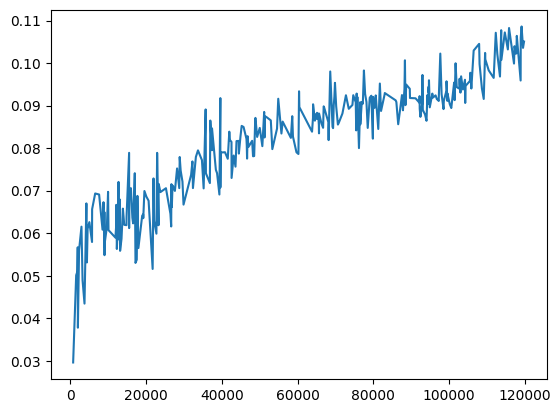

In [200]:
plt.plot(sorted_bls, sorted_cpu_times)

### Benchmark array for GPU times (using same bl array as the cpu case)

In [34]:
# bl_array = np.random.randint(1, 120000, size = 30)

# max = 120000
# stepsize = int(max)/10
# print(stepsize)
# bl_array = int(cp.arange(1, max, stepsize))
bl_array = (cp.linspace(3, 120000, 300)).astype(int)
print(bl_array)
n_eig = 3
n_src = 5
xp = cp  #run things on the gpu using cupy
# noise_mats = np.array([])
noise_mats = []
diff_mats = []
src_mats = []
edges_arr = []
# noise_mats = np.zeros(())
# diff_mats = np.array([])
# src_mats = np.array([])
# edges_arr = np.array([])

for bl in bl_array:
    bl = int(bl)
    edges = xp.unique(xp.random.randint(1, bl-1, size = int(bl*0.01)))
    edges = xp.concatenate((xp.array([0]), edges, xp.array([bl])))
    # print(f"The edges of the redundant blocks have indices{edges}")

    #some random noise, diffuse, and source covariance matrices
    sim_noise_mat = xp.random.rand(bl) + 0.1   #in principle this is squared since is a variance
    sim_diff_mat = xp.random.rand(bl, n_eig)
    sim_src_mat = xp.random.rand(bl, n_src)

    #zeropad the noise, diff, source mats
    zp_sim_noise_mat_inv, largest_block, n_blocks = zeroPad(sim_noise_mat, edges, return_inv=True)  #return inverse set to True to get around div by 0 issue
    zp_sim_noise_mat, largest_block, n_blocks = zeroPad(sim_noise_mat, edges, return_inv=False)  #return inverse set to False for sims later on
    zp_sim_diff_mat, largest_block, n_blocks = zeroPad(sim_diff_mat, edges, return_inv=False)
    zp_sim_src_mat, largest_block, n_blocks = zeroPad(sim_src_mat, edges, return_inv=False)

    #Need to reshape to give an extra dimension of n_blocks to be compatible with inv cov routine
    sim_noise_mat_2d = zp_sim_noise_mat_inv.reshape(n_blocks, largest_block)   #Again, its worth noting the values of the noise mat are really 1/noise_vals here
    sim_diff_mat_3d = zp_sim_diff_mat.reshape(n_blocks, largest_block, n_eig)
    sim_src_mat_3d = zp_sim_src_mat.reshape(n_blocks, largest_block, n_src)

    noise_mats.append(sim_noise_mat_2d)
    diff_mats.append(sim_diff_mat_3d)
    src_mats.append(sim_src_mat_3d)
    edges_arr.append(edges)

[     3    404    805   1206   1608   2009   2410   2812   3213   3614
   4016   4417   4818   5220   5621   6022   6424   6825   7226   7628
   8029   8430   8832   9233   9634  10036  10437  10838  11240  11641
  12042  12444  12845  13246  13648  14049  14450  14852  15253  15654
  16056  16457  16858  17260  17661  18062  18464  18865  19266  19668
  20069  20470  20872  21273  21674  22076  22477  22878  23280  23681
  24082  24483  24885  25286  25687  26089  26490  26891  27293  27694
  28095  28497  28898  29299  29701  30102  30503  30905  31306  31707
  32109  32510  32911  33313  33714  34115  34517  34918  35319  35721
  36122  36523  36925  37326  37727  38129  38530  38931  39333  39734
  40135  40537  40938  41339  41741  42142  42543  42945  43346  43747
  44149  44550  44951  45353  45754  46155  46557  46958  47359  47761
  48162  48563  48964  49366  49767  50168  50570  50971  51372  51774
  52175  52576  52978  53379  53780  54182  54583  54984  55386  55787
  5618

In [ ]:
gpu_times = cp.array([])
cpu_times = cp.array([])
for i, (noise, diff_mat, src_mat, edges_mat) in enumerate(zip(noise_mats, diff_mats, src_mats, edges_arr)):
    print(f"Printing iter {i}")
    test_results = str(benchmark(inverse_covariance, (noise, diff_mat, src_mat, edges_mat, xp, True, True), n_repeat=10))
    # cp.cuda.Stream.null.synchronize()
    test_results = test_results.split()
    cpu_t = float(test_results[3])/1e6
    gpu_t = float(test_results[14])/1e6
    print(f"Time on cpu: {cpu_t:.6f}s")
    print(f"Time on gpu: {gpu_t:.6f}s")
    gpu_times = cp.append(gpu_times, gpu_t)
    cpu_times = cp.append(cpu_times, cpu_t)

Printing iter 0
Time on cpu: 0.001629s
Time on gpu: 0.001640s
Printing iter 1
Time on cpu: 0.001761s
Time on gpu: 0.001778s
Printing iter 2
Time on cpu: 0.001743s
Time on gpu: 0.001754s
Printing iter 3
Time on cpu: 0.001666s
Time on gpu: 0.001686s
Printing iter 4
Time on cpu: 0.001662s
Time on gpu: 0.001673s
Printing iter 5
Time on cpu: 0.001402s
Time on gpu: 0.001425s
Printing iter 6
Time on cpu: 0.001907s
Time on gpu: 0.001920s
Printing iter 7
Time on cpu: 0.002038s
Time on gpu: 0.002054s
Printing iter 8
Time on cpu: 0.001627s
Time on gpu: 0.001648s
Printing iter 9
Time on cpu: 0.001664s
Time on gpu: 0.001681s
Printing iter 10
Time on cpu: 0.002505s
Time on gpu: 0.002533s
Printing iter 11
Time on cpu: 0.001723s
Time on gpu: 0.001750s
Printing iter 12
Time on cpu: 0.001858s
Time on gpu: 0.001924s
Printing iter 13
Time on cpu: 0.002068s
Time on gpu: 0.003139s
Printing iter 14
Time on cpu: 0.001522s
Time on gpu: 0.002284s
Printing iter 15
Time on cpu: 0.001713s
Time on gpu: 0.002230s
Pr

In [36]:
# sorted_bl_idxs = np.argsort(bl_array)
# # print(sorted_bl_idxs)
# sorted_bls = bl_array[sorted_bl_idxs]
# # print(sorted_bls)
# sorted_gpu_times = gpu_times[sorted_bl_idxs]
# # print(sorted_cpu_times)

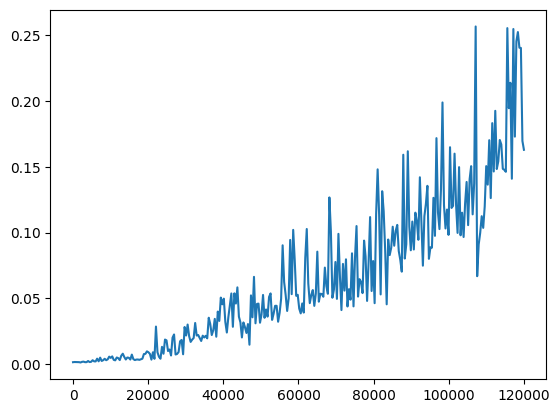

In [37]:
plt.plot(cp.asnumpy(bl_array), cp.asnumpy(gpu_times))
# plt.plot(cp.asnumpy(bl_array), cp.asnumpy(cpu_times))


In [201]:
print(sorted_bls)

[   701   1504   1812   1913   1957   2267   2902   3191   3703   4200
   4342   4526   4987   5691   5716   6523   7564   8465   8724   8930
   8959   8979   9026   9044   9055   9617   9930  10043  11871  12049
  12104  12251  12449  12693  12849  12960  13110  13483  13848  14200
  14793  14817  15491  15496  15517  15962  16352  16547  16989  17177
  17513  17592  17683  17942  18945  19206  19228  19535  20051  20638
  21709  21939  22099  22705  22895  23258  23304  23759  25222  26405
  26609  26671  26776  26934  27040  27589  28166  28745  28859  29113
  29590  29870  31873  32221  32358  33132  33686  34731  35184  35714
  35783  36833  36948  37376  37401  38414  38733  39347  39599  39604
  39677  40826  41558  41964  42135  42545  42569  43121  43600  43871
  44452  44494  44916  45232  45733  46496  46579  46660  46800  47025
  48004  48238  48537  48815  48873  49324  50013  50697  51179  51274
  51385  51839  52932  53333  54577  54898  55740  56066  58234  58597
  5878

### Trying benchmark tests again, but combining the two loops

In [46]:
# bl_array = np.random.randint(1, 120000, size = 30)
import gc
gpu_times = cp.array([])
cpu_times = cp.array([])
# max = 120000
# stepsize = int(max)/10
# print(stepsize)
# bl_array = int(cp.arange(1, max, stepsize))
bl_array = (np.linspace(3, 120000, 30)).astype(int)
# print(bl_array)
n_eig = 3
n_src = 5
xp = cp  #run things on the gpu using cupy

# noise_mats = np.zeros(())
# diff_mats = np.array([])
# src_mats = np.array([])
# edges_arr = np.array([])

for i, bl in enumerate(bl_array):
    bl = int(bl)
    edges = xp.unique(xp.random.randint(1, bl-1, size = max(int(bl*0.01), 1)))
    edges = xp.concatenate((xp.array([0]), edges, xp.array([bl])))
    # print(f"The edges of the redundant blocks have indices{edges}")

    #some random noise, diffuse, and source covariance matrices
    sim_noise_mat = xp.random.rand(bl) + 0.1   #in principle this is squared since is a variance
    sim_diff_mat = xp.random.rand(bl, n_eig)
    sim_src_mat = xp.random.rand(bl, n_src)

    #zeropad the noise, diff, source mats
    zp_sim_noise_mat_inv, largest_block, n_blocks = zeroPad(sim_noise_mat, edges, return_inv=True)  #return inverse set to True to get around div by 0 issue
    zp_sim_noise_mat, largest_block, n_blocks = zeroPad(sim_noise_mat, edges, return_inv=False)  #return inverse set to False for sims later on
    zp_sim_diff_mat, largest_block, n_blocks = zeroPad(sim_diff_mat, edges, return_inv=False)
    zp_sim_src_mat, largest_block, n_blocks = zeroPad(sim_src_mat, edges, return_inv=False)

    #Need to reshape to give an extra dimension of n_blocks to be compatible with inv cov routine
    sim_noise_mat_2d = zp_sim_noise_mat_inv.reshape(n_blocks, largest_block)   #Again, its worth noting the values of the noise mat are really 1/noise_vals here
    sim_diff_mat_3d = zp_sim_diff_mat.reshape(n_blocks, largest_block, n_eig)
    sim_src_mat_3d = zp_sim_src_mat.reshape(n_blocks, largest_block, n_src)

    print(f"Printing iter {i}")
    mem_before = cp.get_default_memory_pool().used_bytes()
    test_results = str(benchmark(inverse_covariance, (sim_noise_mat_2d, sim_diff_mat_3d, sim_src_mat_3d, edges, xp, True, True), n_repeat=10))
    mem_after = cp.get_default_memory_pool().used_bytes()
    print(f"Memory used: {mem_after - mem_before} bytes")
    cp.cuda.Stream.null.synchronize()
    
    test_results = test_results.split()
    cpu_t = float(test_results[3])/1e6
    gpu_t = float(test_results[14])/1e6
    print(f"Time on cpu: {cpu_t:.6f}s")
    print(f"Time on gpu: {gpu_t:.6f}s")
    gpu_times = cp.append(gpu_times, gpu_t)
    cpu_times = cp.append(cpu_times, cpu_t)
    del sim_noise_mat_2d, sim_diff_mat_3d, sim_src_mat_3d, edges
    cp._default_memory_pool.free_all_blocks()  # Free all unused memory blocks
    # gc.collect()  # Run garbage collector

Printing iter 0
Memory used: 0 bytes
Time on cpu: 0.001635s
Time on gpu: 0.001770s
Printing iter 1
Memory used: 0 bytes
Time on cpu: 0.002389s
Time on gpu: 0.007269s
Printing iter 2
Memory used: 0 bytes
Time on cpu: 0.001780s
Time on gpu: 0.004403s
Printing iter 3
Memory used: 0 bytes
Time on cpu: 0.002230s
Time on gpu: 0.005051s
Printing iter 4
Memory used: 0 bytes
Time on cpu: 0.002483s
Time on gpu: 0.012235s
Printing iter 5
Memory used: 0 bytes
Time on cpu: 0.002545s
Time on gpu: 0.004605s
Printing iter 6
Memory used: 0 bytes
Time on cpu: 0.002816s
Time on gpu: 0.006529s
Printing iter 7
Memory used: 0 bytes
Time on cpu: 0.002786s
Time on gpu: 0.031366s
Printing iter 8
Memory used: 0 bytes
Time on cpu: 0.002352s
Time on gpu: 0.024626s
Printing iter 9
Memory used: 0 bytes
Time on cpu: 0.002646s
Time on gpu: 0.020869s
Printing iter 10
Memory used: 0 bytes
Time on cpu: 0.002475s
Time on gpu: 0.061752s
Printing iter 11
Memory used: 0 bytes
Time on cpu: 0.002347s
Time on gpu: 0.049044s
Pr

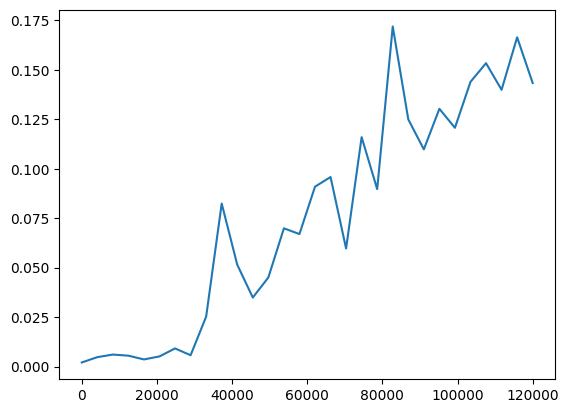

In [43]:
plt.plot(cp.asnumpy(bl_array), cp.asnumpy(gpu_times))


In [45]:
import cupy as cp
import numpy as np

# Function to time GPU functions accurately
def time_function(func, *args):
    start = cp.cuda.Event()
    end = cp.cuda.Event()
    start.record()
    func(*args)
    end.record()
    end.synchronize()
    elapsed_time = cp.cuda.get_elapsed_time(start, end)  # Time in milliseconds
    return elapsed_time / 1000  # Convert to seconds

# Initialize timing lists
gpu_times = []

# Use NumPy array for bl_array
bl_array = np.linspace(3, 120000, 30).astype(int)
n_eig = 3
n_src = 5
xp = cp  # Run things on the GPU using CuPy

for i, bl in enumerate(bl_array):
    print(f"Processing iteration {i}, bl size: {bl}")
    bl = int(bl)
    edge_size = max(int(bl * 0.01), 1)  # Ensure at least one edge
    edges = xp.unique(xp.random.randint(1, bl - 1, size=edge_size))
    edges = xp.concatenate((xp.array([0]), edges, xp.array([bl])))

    # Generate random matrices
    sim_noise_mat = xp.random.rand(bl) + 0.1
    sim_diff_mat = xp.random.rand(bl, n_eig)
    sim_src_mat = xp.random.rand(bl, n_src)

    # Zero-pad matrices
    zp_sim_noise_mat_inv, largest_block, n_blocks = zeroPad(sim_noise_mat, edges, return_inv=True)
    zp_sim_diff_mat, _, _ = zeroPad(sim_diff_mat, edges, return_inv=False)
    zp_sim_src_mat, _, _ = zeroPad(sim_src_mat, edges, return_inv=False)

    # Reshape matrices
    sim_noise_mat_2d = zp_sim_noise_mat_inv.reshape(n_blocks, largest_block)
    sim_diff_mat_3d = zp_sim_diff_mat.reshape(n_blocks, largest_block, n_eig)
    sim_src_mat_3d = zp_sim_src_mat.reshape(n_blocks, largest_block, n_src)

    # Warm-up
    inverse_covariance(sim_noise_mat_2d, sim_diff_mat_3d, sim_src_mat_3d, edges, xp, True, True)
    cp.cuda.Stream.null.synchronize()

    # Time the inverse_covariance function
    gpu_t = 0.0
    n_repeat = 10
    for _ in range(n_repeat):
        gpu_t += time_function(
            inverse_covariance,
            sim_noise_mat_2d, sim_diff_mat_3d, sim_src_mat_3d, edges, xp, True, True
        )
    gpu_t /= n_repeat  # Average time per iteration

    print(f"Time on GPU: {gpu_t:.6f}s")
    gpu_times.append(gpu_t)

    # Clean up variables (optional, as Python's garbage collector will handle it)
    del sim_noise_mat_2d, sim_diff_mat_3d, sim_src_mat_3d, edges
    del sim_noise_mat, sim_diff_mat, sim_src_mat
    del zp_sim_noise_mat_inv, zp_sim_diff_mat, zp_sim_src_mat
    # No need to free memory pool or force garbage collection

# Optionally, convert gpu_times to a NumPy array for plotting or further analysis
gpu_times = np.array(gpu_times)


Processing iteration 0, bl size: 3
Time on GPU: 0.002133s
Processing iteration 1, bl size: 4140
Time on GPU: 0.015426s
Processing iteration 2, bl size: 8278
Time on GPU: 0.006350s
Processing iteration 3, bl size: 12416
Time on GPU: 0.003634s
Processing iteration 4, bl size: 16554
Time on GPU: 0.007006s
Processing iteration 5, bl size: 20692
Time on GPU: 0.024195s
Processing iteration 6, bl size: 24829
Time on GPU: 0.027748s
Processing iteration 7, bl size: 28967
Time on GPU: 0.017693s
Processing iteration 8, bl size: 33105
Time on GPU: 0.034925s
Processing iteration 9, bl size: 37243
Time on GPU: 0.052585s
Processing iteration 10, bl size: 41381
Time on GPU: 0.044900s
Processing iteration 11, bl size: 45519
Time on GPU: 0.045649s
Processing iteration 12, bl size: 49656
Time on GPU: 0.061518s
Processing iteration 13, bl size: 53794
Time on GPU: 0.101714s
Processing iteration 14, bl size: 57932
Time on GPU: 0.057697s
Processing iteration 15, bl size: 62070
Time on GPU: 0.090344s
Processi

KeyboardInterrupt: 